In [3]:
import cooler 
import cooltools
import cooltools.lib.plotting


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob#用来查找文件路径


from coolbox.utilities.genome import GenomeRange
from coolbox.api import *

import re

import sys
#对于模块和自己写的脚本不在同一个目录下
sys.path.append("/shareb/zliu/analysis/hires_gastrulation/")
from CHARMtools import structure

In [4]:
#作图的刻度设置
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')#单位

#设置刻度
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=0)

In [5]:
#基因组注释文件
gtf = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/annotation.gtf"

In [6]:
#细胞类型
celltype = pd.read_csv("/shareb/zliu/analysis/hires_mouse_dev/metadata_qcpass.tsv",sep="\t")
celltype = celltype.query('rmsd_20k < 1.5') #

In [7]:
#scale过的细胞cool文件
celltype1_scalepath = ["/shareb/zliu/analysis/hires_mouse_dev/figure3_related/d3d_res_analysis/obs_exp/cools_scale_distance/"+i+".distance.20k.cool" for i in celltype.query('celltype in ["early neurons"] & cellcycle_threshold == "G0"')["cellname"].values.T]
celltype2_scalepath = ["/shareb/zliu/analysis/hires_mouse_dev/figure3_related/d3d_res_analysis/obs_exp/cools_scale_distance/"+i+".distance.20k.cool" for i in celltype.query('celltype in ["mix late mesenchyme"]  & cellcycle_threshold == "G0" ')["cellname"].values.T]

#没scale的细胞的cool文件
celltype1_path = ["/shareb/zliu/analysis/hires_mouse_dev/figure3_related/d3d_res_analysis/obs_exp/cools_distance/"+i+".distance.20k.cool" for i in celltype.query('celltype in ["early neurons"] & cellcycle_threshold == "G0"')["cellname"].values.T]
celltype2_path = ["/shareb/zliu/analysis/hires_mouse_dev/figure3_related/d3d_res_analysis/obs_exp/cools_distance/"+i+".distance.20k.cool" for i in celltype.query('celltype in ["mix late mesenchyme"]  & cellcycle_threshold == "G0" ')["cellname"].values.T]


In [8]:
#分辨率 binsize
resolution=20000

#筛选出来的一些东西

scale_site_bedpe = pd.read_csv("/shareb/zliu/analysis/hires_mouse_dev/figure3_new/scale/neuron_mesenchyme.g0.scale.filter.differences",sep="\t").iloc[:,:6] #.query('abs(diff)>0.2')
scale_site_bedpe.columns = ["chrom1","start1","end1","chrom2","start2","end2"]
scale_site_bedpe["chrom2"] = scale_site_bedpe["chrom1"]
#取几列出来
scale_site_bedpe = scale_site_bedpe[["chrom1","start1","end1","chrom2","start2","end2"]]

In [13]:
#取数据的函数
'''
a:矩阵
k:int
'''
def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

In [16]:
#bigwig作图的函数
def plot_bigwig(ax,frame,name):
    ax_big = frame.plot(ax,gr=GenomeRange(genome_coord))
    
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(name,fontsize=6,x=0.8,y=0)

In [11]:
#生成相应的BED文件
def generate_bed(raw_bed,chr,gene):
    import os
    command = f"cat {raw_bed} | grep {chr} | grep -E 'fake|{gene}' > {gene}.bed"
    os.system(command)





## version 1

[W::hts_idx_load3] The index file is older than the data file: ./Add3_fake.bed.bgz.tbi


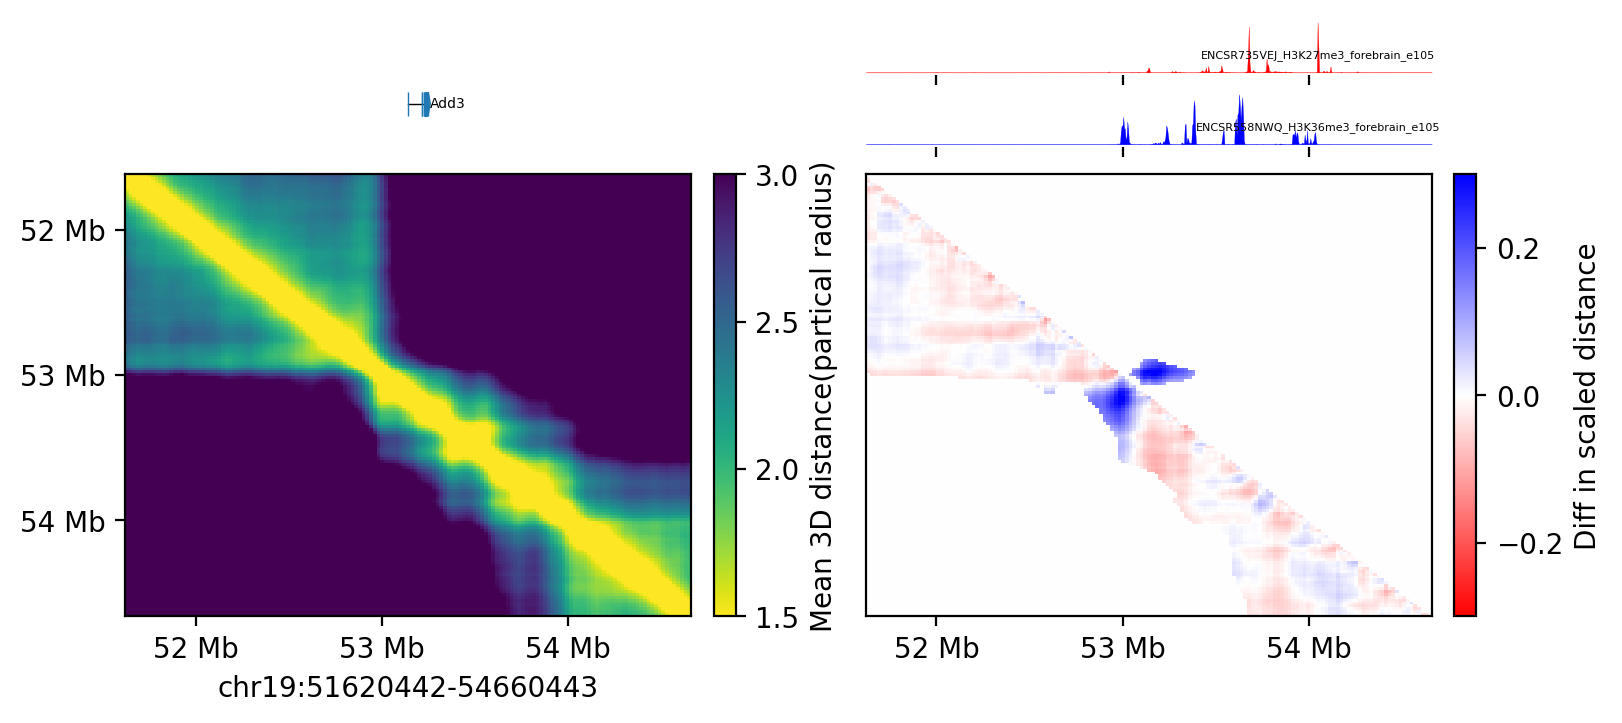

In [11]:
#定义研究范围
gene = "Dcc"
genome_coord="chr19:51,620,442-54,660,443"
genome_coord_pat = genome_coord.replace(":","pat:")
genome_coord_mat = genome_coord.replace(":","mat:")

#准备数据
#细胞类型1
mat1 = np.mean([structure.get3dProximityStackMatrix(celltype1_path,genome_coord1=genome_coord_pat),
                structure.get3dProximityStackMatrix(celltype1_path,genome_coord1=genome_coord_mat)],axis=0)
#细胞类型2
mat2 = np.mean([structure.get3dProximityStackMatrix(celltype2_path,genome_coord1=genome_coord_pat),
                structure.get3dProximityStackMatrix(celltype2_path,genome_coord1=genome_coord_mat)],axis=0)


mat1_scale = np.mean([structure.get3dProximityStackMatrix(celltype1_scalepath,genome_coord1=genome_coord_pat),
                structure.get3dProximityStackMatrix(celltype1_scalepath,genome_coord1=genome_coord_mat)],axis=0)

mat2_scale = np.mean([structure.get3dProximityStackMatrix(celltype2_scalepath,genome_coord1=genome_coord_pat),
                structure.get3dProximityStackMatrix(celltype2_scalepath,genome_coord1=genome_coord_mat)],axis=0)


#左下角的矩阵
normal_mat=np.triu(mat1)+np.tril(mat2)
#右下角的矩阵
diff_mat=mat1_scale - mat2_scale
#特定的位点
site_bedpe=scale_site_bedpe
#分辨率
resolution=20000

#对坐标做一些处理
genome_coord = genome_coord.replace(",","")
genome_coord_split=re.split(string = genome_coord, pattern = "[:-]")
genome_coord_split[1] = int(genome_coord_split[1])#起点
genome_coord_split[2] = int(genome_coord_split[2])#终点
genome_length = genome_coord_split[2] - genome_coord_split[1]#基因的长度
start_cor=genome_coord_split[1]
gr = GenomeRange(genome_coord)


#创建画布
f, ax = plt.subplots(ncols=2,nrows=3,
        figsize=(8,3.5),dpi=200
        ,sharex='col'
        # ,sharey='row'
        ,constrained_layout=True,gridspec_kw={'height_ratios': [1,1,8]}
    )


#【左上】
gene_bed = "./Add3_fake.bed"
gtfframe = BED(gene_bed
            ,gene_style='flybase'
            ,height=0.01
            ,fontsize=5
            ,num_rows=1
            )
ax0 = gtfframe.plot(ax[1,0],gr=GenomeRange(genome_coord)) 
ax[1,0].axis('off')
ax[0,0].axis('off')


#【2】右上
data_dir = "/share/Data/mliu/project1/0913_get_data/data"

name1 = "ENCSR735VEJ_H3K27me3_forebrain_e105"
bw1 = f"{data_dir}/{name1}.bigWig"
frame1 =BigWig(bw1, alpha=1) + Color("red") 

name2 = "ENCSR558NWQ_H3K36me3_forebrain_e105"
bw2 = f"{data_dir}/{name2}.bigWig"
frame2 =BigWig(bw2, alpha=1) + Color("blue") 

plot_bigwig(ax[0,1],frame1,name1)
plot_bigwig(ax[1,1],frame2,name2)


#【左下】
#进行一些修改
for i in range(int(2000000/resolution), normal_mat.shape[0]):
    normal_mat[kth_diag_indices(normal_mat,i)] = 1000
    normal_mat[kth_diag_indices(normal_mat,-i)] = 1000

ax1 = ax[-1,0]
im = ax[-1,0].matshow(
    normal_mat,cmap="viridis_r",vmax = 3, vmin=1.5,extent = [gr.start,gr.end,gr.end,gr.start],
    interpolation='nearest', aspect='auto'
);
#添加渐变条
cb = plt.colorbar(im, ax=ax[-1,0] ,fraction=0.046, pad=0.04, label='Mean 3D distance(partical radius)');
cb.ax.locator_params(nbins = 5)
format_ticks(ax1)


ax1.locator_params(axis='both', nbins=4)
ax1.set(xlabel=genome_coord)

#【右下】
ax2 = ax[-1,1]
#标记【特定的点（原来黑色的区域）】
cor_list = []
for site in site_bedpe.query('chrom1 == @genome_coord_split[0] & start1 > @genome_coord_split[1] & end1 < @genome_coord_split[2] & chrom2 == @genome_coord_split[0] & start2 > @genome_coord_split[1] & end2 < @genome_coord_split[2]').values.tolist():
    
    x = (site[1] + site[2]) / 2#pair1
    y = (site[4] + site[5]) / 2#pair2
    x_loc = int((x - start_cor) / resolution)
    y_loc = int((y - start_cor) / resolution)
    cor_list.append((x_loc,y_loc))
    

#修改上三角
for r in range(diff_mat.shape[0]):
    for c in range(r+1, diff_mat.shape[0]):
        cor = (r,c)
        if(cor in cor_list):
            pass
        else:
            diff_mat[r,c] = 0
            
    
#修改下三角
#找到距离太大的pair
threshold = 3
xy = np.where(normal_mat > threshold)
fill_list = []
for i in range(xy[0].shape[0]):
    x = xy[0][i]
    y = xy[1][i]
    fill_list.append((x,y))

#修改diff_mat对应的部分   
for r in range(diff_mat.shape[0]):
    for c in range(0, r):
        cor = (r,c)
        if (cor in fill_list):
            diff_mat[r,c] = 0
        else:
            pass
           
im2 = ax[-1,1].matshow(diff_mat
                      ,cmap="bwr_r",vmax = 0.3, vmin=-0.3
                    ,extent = [gr.start,gr.end,gr.end,gr.start]
                    ,interpolation='nearest', aspect='auto'

                    );


ax[-1,1].get_shared_y_axes().join(ax[-1,0], ax[-1,1])
ax[-1,1].set_yticks([])


#添加颜色bar
cb = plt.colorbar(im2, ax=ax[-1,1] ,fraction=0.046, pad=0.04, label='Diff in scaled distance');
cb.ax.locator_params(nbins = 5)
#设置刻度格式
format_ticks(ax2)
ax2.locator_params(axis='both', nbins=4)




### forebrain_plot

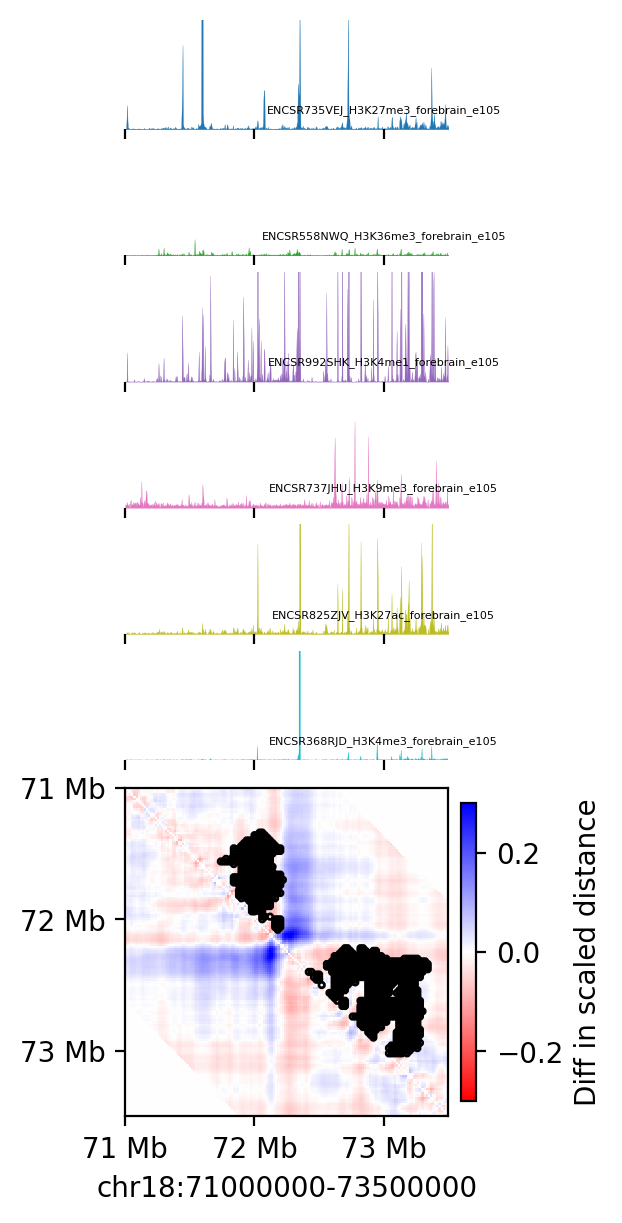

In [12]:

    

data_dir = "/share/Data/mliu/project1/0913_get_data/data"
bw_name_list = ["ENCSR735VEJ_H3K27me3_forebrain_e105",
                "ENCSR558NWQ_H3K36me3_forebrain_e105"
                ,"ENCSR992SHK_H3K4me1_forebrain_e105",
               "ENCSR737JHU_H3K9me3_forebrain_e105",
                "ENCSR825ZJV_H3K27ac_forebrain_e105",
                "ENCSR368RJD_H3K4me3_forebrain_e105"]

color_list = plt.cm.tab10(np.linspace(0, 1, 6))
frame_list = []

for i,name in enumerate(bw_name_list):
    bw_name = name
    bw = f"{data_dir}/{name}.bigWig"
    frame =BigWig(bw, alpha=1) + Color(color_list[i]) + MaxValue(5) + MinValue(0)
    frame_list.append(frame)
    

genome_coord="chr18:71,000,000-73,500,000"
diff_mat=mat1_scale - mat2_scale
normal_mat=np.triu(mat1)+np.tril(mat2)
site_bedpe=scale_site_bedpe
resolution=20000
gr = GenomeRange(genome_coord)
genome_coord = genome_coord.replace(",","")
genome_coord_split=re.split(string = genome_coord, pattern = "[:-]")
genome_coord_split[1] = int(genome_coord_split[1])
genome_coord_split[2] = int(genome_coord_split[2])
genome_length = genome_coord_split[2] - genome_coord_split[1]


for i in range(int(2000000/resolution), normal_mat.shape[0]):
    normal_mat[kth_diag_indices(normal_mat,i)] = 1000
    normal_mat[kth_diag_indices(normal_mat,-i)] = 1000

#创建画布
height_list = [1]*len(bw_name_list)+[3]

f, ax = plt.subplots(ncols=1,nrows=(1+len(bw_name_list)),facecolor="white",
    figsize=(3,6),dpi=200,sharex=True,sharey="row",gridspec_kw={'height_ratios': height_list},constrained_layout=True
)



#【1】
for i in range(len(bw_name_list)):
    plot_bigwig(ax[i],frame_list[i],bw_name_list[i])


#【2】
ax2_heat = ax[-1]
im2 = ax[-1].matshow(
    diff_mat,cmap="bwr_r",vmax = 0.3, vmin=-0.3,extent = [gr.start,gr.end,gr.end,gr.start],
    interpolation='nearest', aspect='auto'
);
cb = plt.colorbar(im2, ax=ax[-1] ,fraction=0.046, pad=0.04, label='Diff in scaled distance');
cb.ax.locator_params(nbins = 5)
format_ticks(ax2_heat)
if site_bedpe is not None:
    for site in site_bedpe.query('chrom1 == @genome_coord_split[0] & start1 > @genome_coord_split[1] & end1 < @genome_coord_split[2] & chrom2 == @genome_coord_split[0] & start2 > @genome_coord_split[1] & end2 < @genome_coord_split[2]').values.tolist():
        ax2_heat.add_artist(plt.Circle(((site[4]+site[5])/2,(site[1]+site[2])/2),radius=0.5*resolution,color="black",alpha=1,fill=False,linewidth=2))
ax2_heat.set(xlabel=genome_coord)
ax2_heat.locator_params(axis='both', nbins=4)

## version 2

Dcc.bed


[W::hts_idx_load3] The index file is older than the data file: Dcc.bed.bgz.tbi


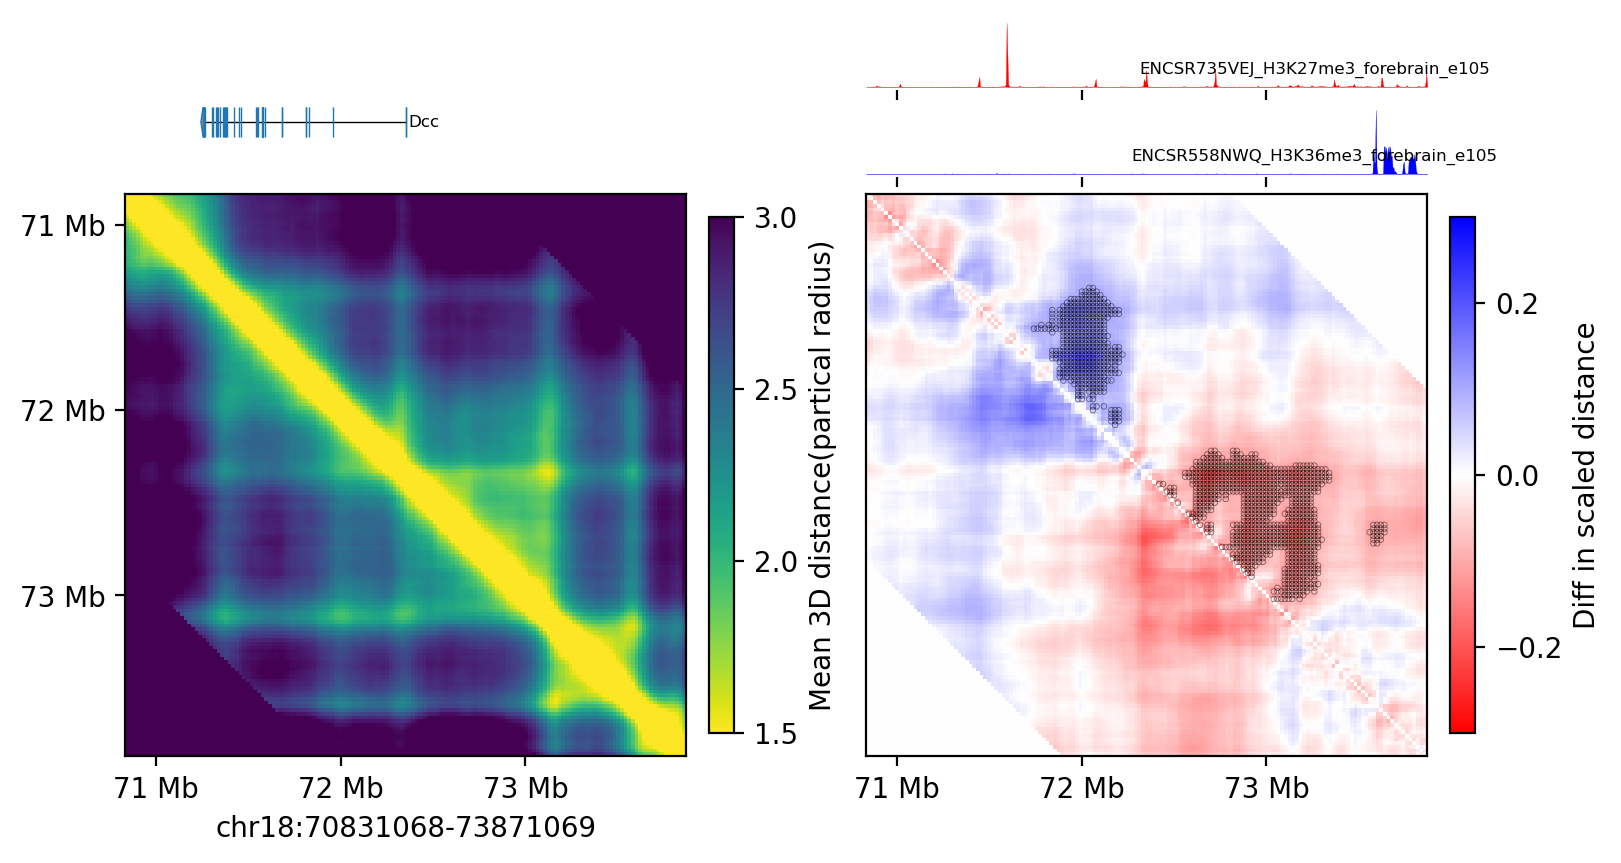

In [18]:
#定义研究范围
target_gene = "Dcc"
genome_coord="chr18:70,831,068-73,871,069"
genome_coord_pat = genome_coord.replace(":","pat:")
genome_coord_mat = genome_coord.replace(":","mat:")

#定义bed文件的地址
raw_bed = "/share/home/mliu/project1/M23UCSC_genes_symbol_subset.bed"

#准备数据(根据genome_coord来取相应的部分)
#细胞类型1
'''
mat1 = np.mean([structure.get3dProximityStackMatrix(celltype1_path,genome_coord1=genome_coord_pat),
                structure.get3dProximityStackMatrix(celltype1_path,genome_coord1=genome_coord_mat)],axis=0)
#细胞类型2
mat2 = np.mean([structure.get3dProximityStackMatrix(celltype2_path,genome_coord1=genome_coord_pat),
                structure.get3dProximityStackMatrix(celltype2_path,genome_coord1=genome_coord_mat)],axis=0)


mat1_scale = np.mean([structure.get3dProximityStackMatrix(celltype1_scalepath,genome_coord1=genome_coord_pat),
                structure.get3dProximityStackMatrix(celltype1_scalepath,genome_coord1=genome_coord_mat)],axis=0)

mat2_scale = np.mean([structure.get3dProximityStackMatrix(celltype2_scalepath,genome_coord1=genome_coord_pat),
                structure.get3dProximityStackMatrix(celltype2_scalepath,genome_coord1=genome_coord_mat)],axis=0)
'''

#左下角的矩阵
normal_mat=np.triu(mat1)+np.tril(mat2)
#右下角的矩阵
diff_mat=mat1_scale - mat2_scale
#特定的位点
site_bedpe=scale_site_bedpe
#分辨率
resolution=20000


#对坐标做一些处理
genome_coord = genome_coord.replace(",","")
genome_coord_split=re.split(string = genome_coord, pattern = "[:-]")
genome_coord_split[1] = int(genome_coord_split[1])#起点
genome_coord_split[2] = int(genome_coord_split[2])#终点
genome_length = genome_coord_split[2] - genome_coord_split[1]#基因的长度
start_cor=genome_coord_split[1]
gr = GenomeRange(genome_coord)


#创建画布
f, ax = plt.subplots(ncols=2,nrows=3,
        figsize=(8,4.2),dpi=200
        ,sharex='col'
        # ,sharey='row'
        ,constrained_layout=True,gridspec_kw={'height_ratios': [1,1,8]}
    )


#【左上】
generate_bed(raw_bed,"chr18",target_gene)
gene_bed = f"{target_gene}.bed"
print(gene_bed)
gtfframe = BED(gene_bed
            ,gene_style='flybase'
            ,height=0.01
            ,fontsize=6
            ,num_rows=1
            )
ax0 = gtfframe.plot(ax[1,0],gr=GenomeRange(genome_coord)) 
ax[1,0].axis('off')
ax[0,0].axis('off')


#【2】右上
data_dir = "/share/Data/mliu/project1/0913_get_data/data"

name1 = "ENCSR735VEJ_H3K27me3_forebrain_e105"
bw1 = f"{data_dir}/{name1}.bigWig"
frame1 =BigWig(bw1, alpha=1) + Color("red") 

name2 = "ENCSR558NWQ_H3K36me3_forebrain_e105"
bw2 = f"{data_dir}/{name2}.bigWig"
frame2 =BigWig(bw2, alpha=1) + Color("blue") 

plot_bigwig(ax[0,1],frame1,name1)
plot_bigwig(ax[1,1],frame2,name2)


#【左下】
#进行一些修改
for i in range(int(2000000/resolution), normal_mat.shape[0]):
    normal_mat[kth_diag_indices(normal_mat,i)] = 1000
    normal_mat[kth_diag_indices(normal_mat,-i)] = 1000

ax1 = ax[-1,0]
im = ax[-1,0].matshow(
    normal_mat,cmap="viridis_r",vmax = 3, vmin=1.5,extent = [gr.start,gr.end,gr.end,gr.start],
    interpolation='nearest', aspect='auto'
);
#添加渐变条
cb = plt.colorbar(im, ax=ax[-1,0] ,fraction=0.046, pad=0.04, label='Mean 3D distance(partical radius)');
cb.ax.locator_params(nbins = 5)
format_ticks(ax1)


ax1.locator_params(axis='both', nbins=4)
ax1.set(xlabel=genome_coord)

#【右下】
ax2 = ax[-1,1]
#标记【特定的点（原来黑色的区域）】
     
im2 = ax[-1,1].matshow(diff_mat
                      ,cmap="bwr_r",vmax = 0.3, vmin=-0.3
                    ,extent = [gr.start,gr.end,gr.end,gr.start]
                    ,interpolation='nearest', aspect='auto'

                    );


ax[-1,1].get_shared_y_axes().join(ax[-1,0], ax[-1,1])
ax[-1,1].set_yticks([])


#添加颜色bar
cb = plt.colorbar(im2, ax=ax[-1,1] ,fraction=0.046, pad=0.04, label='Diff in scaled distance');
cb.ax.locator_params(nbins = 5)
#设置刻度格式
format_ticks(ax2)
ax2.locator_params(axis='both', nbins=4)

if site_bedpe is not None:
    for site in site_bedpe.query('chrom1 == @genome_coord_split[0] & start1 > @genome_coord_split[1] & end1 < @genome_coord_split[2] & chrom2 == @genome_coord_split[0] & start2 > @genome_coord_split[1] & end2 < @genome_coord_split[2]').values.tolist():
        ax2.add_artist(plt.Circle(((site[4]+site[5])/2,(site[1]+site[2])/2),radius=0.1*resolution,color="black",alpha=0.5,fill=False,linewidth=2))


